# SetFit Text Classification Hyperparameter Search

In this notebook, we'll learn how to do hyperparameter search with SetFit.

## Setup

If you're running this Notebook on Colab or some other cloud platform, you will need to install the `setfit` and `optuna` libraries. Uncomment the following cell and run it:

In [1]:
# %pip install setfit[optuna] matplotlib

In [1]:
import numpy as np
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer

First, we prepare the dataset. For details, see the multilabel training notebook.

In [2]:
def encode_labels(record):
    return {"labels": [record[feature] for feature in features]}


num_samples = 8
dataset = load_dataset("ethos", "multilabel")

features = dataset["train"].column_names
features.remove("text")
samples = np.concatenate([np.random.choice(np.where(dataset["train"][f])[0], num_samples) for f in features])
dataset = dataset.map(encode_labels)
train_dataset = dataset["train"].select(samples)
eval_dataset = dataset["train"].select(np.setdiff1d(np.arange(len(dataset["train"])), samples))

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/433 [00:00<?, ? examples/s]

Dataset ethos downloaded and prepared to /root/.cache/huggingface/datasets/ethos/multilabel/1.0.0/898d3d005459ee3ff80dbeec2f169c6b7ea13de31a08458193e27dec3dd9ae38. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/433 [00:00<?, ? examples/s]

## Hyperparameter search
For a hyperparameter search we need several changes to the normal training setup:

* Instead of a model, we pass a `model_init` function, which optionally can use the dictionary of hyperparameters
* We set up a function that defines which parameters we are interested in optimizing

In [3]:
model_id = "sentence-transformers/paraphrase-mpnet-base-v2"


def make_model(params=None):
    multi_target_strategy = params["multi_target_strategy"] if params else "one-vs-rest"
    return SetFitModel.from_pretrained(
        model_id, multi_target_strategy=multi_target_strategy
    )

In [4]:
trainer = SetFitTrainer(
    model_init=make_model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss_class=CosineSimilarityLoss,
    num_epochs=1,
    num_iterations=5,
    column_mapping={"text": "text", "labels": "label"},
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


For this particular trial, we try to find the optimal learning rate, `multi_target_strategy`, and batch size for training with only 5 iterations on 8 samples/class:

In [5]:
def hyperparameter_search_function(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [4, 8, 16, 32]),
        "multi_target_strategy": trial.suggest_categorical("multi_target_strategy", ["one-vs-rest", "multi-output", "classifier-chain"])
    }

Now, we are ready to do the hyperparameter search. The default settings maximize accuracy, which is fine here. As we are searching 3 parameters, we choose a slightly higher number of trials than the default 10:

In [6]:
best = trainer.hyperparameter_search(hyperparameter_search_function, n_trials=10)
best

[I 2023-02-28 18:34:43,359] A new study created in memory with name: no-name-5ed03166-b50d-4056-952b-5b857f1b623c
Trial: {'learning_rate': 2.1172740293073367e-05, 'batch_size': 4, 'multi_target_strategy': 'classifier-chain'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 970
  Num epochs = 1
  Total optimization steps = 243
  Total train batch size = 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/243 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****


[I 2023-02-28 18:35:26,808] Trial 0 finished with value: 0.392 and parameters: {'learning_rate': 2.1172740293073367e-05, 'batch_size': 4, 'multi_target_strategy': 'classifier-chain'}. Best is trial 0 with value: 0.392.
Trial: {'learning_rate': 1.3026917738850252e-05, 'batch_size': 8, 'multi_target_strategy': 'classifier-chain'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 970
  Num epochs = 1
  Total optimization steps = 122
  Total train batch size = 8


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/122 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-02-28 18:35:58,031] Trial 1 finished with value: 0.368 and parameters: {'learning_rate': 1.3026917738850252e-05, 'batch_size': 8, 'multi_target_strategy': 'classifier-chain'}. Best is trial 0 with value: 0.392.
Trial: {'learning_rate': 1.647439432650133e-05, 'batch_size': 4, 'multi_target_strategy': 'classifier-chain'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 970
  Num epochs = 1
  Total optimization steps = 243
  Total train batch size = 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/243 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-02-28 18:36:37,662] Trial 2 finished with value: 0.37333333333333335 and parameters: {'learning_rate': 1.647439432650133e-05, 'batch_size': 4, 'multi_target_strategy': 'classifier-chain'}. Best is trial 0 with value: 0.392.
Trial: {'learning_rate': 0.0004517431005221925, 'batch_size': 8, 'multi_target_strategy': 'classifier-chain'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 970
  Num epochs = 1
  Total optimization steps = 122
  Total train batch size = 8


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/122 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-02-28 18:37:08,924] Trial 3 finished with value: 0.0 and parameters: {'learning_rate': 0.0004517431005221925, 'batch_size': 8, 'multi_target_strategy': 'classifier-chain'}. Best is trial 0 with value: 0.392.
Trial: {'learning_rate': 1.942577360845342e-05, 'batch_size': 8, 'multi_target_strategy': 'multi-output'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 970
  Num epochs = 1
  Total optimization steps = 122
  Total train batch size = 8


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/122 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-02-28 18:37:41,032] Trial 4 finished with value: 0.38666666666666666 and parameters: {'learning_rate': 1.942577360845342e-05, 'batch_size': 8, 'multi_target_strategy': 'multi-output'}. Best is trial 0 with value: 0.392.
Trial: {'learning_rate': 6.373867814145844e-05, 'batch_size': 32, 'multi_target_strategy': 'classifier-chain'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 970
  Num epochs = 1
  Total optimization steps = 31
  Total train batch size = 32


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/31 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-02-28 18:38:18,398] Trial 5 finished with value: 0.33866666666666667 and parameters: {'learning_rate': 6.373867814145844e-05, 'batch_size': 32, 'multi_target_strategy': 'classifier-chain'}. Best is trial 0 with value: 0.392.
Trial: {'learning_rate': 4.577708618256612e-05, 'batch_size': 16, 'multi_target_strategy': 'classifier-chain'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 970
  Num epochs = 1
  Total optimization steps = 61
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/61 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-02-28 18:38:51,243] Trial 6 finished with value: 0.3973333333333333 and parameters: {'learning_rate': 4.577708618256612e-05, 'batch_size': 16, 'multi_target_strategy': 'classifier-chain'}. Best is trial 6 with value: 0.3973333333333333.
Trial: {'learning_rate': 0.0002003002439427176, 'batch_size': 16, 'multi_target_strategy': 'multi-output'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 970
  Num epochs = 1
  Total optimization steps = 61
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/61 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-02-28 18:39:23,137] Trial 7 finished with value: 0.34933333333333333 and parameters: {'learning_rate': 0.0002003002439427176, 'batch_size': 16, 'multi_target_strategy': 'multi-output'}. Best is trial 6 with value: 0.3973333333333333.
Trial: {'learning_rate': 2.4138701946865154e-05, 'batch_size': 32, 'multi_target_strategy': 'one-vs-rest'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 970
  Num epochs = 1
  Total optimization steps = 31
  Total train batch size = 32


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/31 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-02-28 18:40:00,128] Trial 8 finished with value: 0.376 and parameters: {'learning_rate': 2.4138701946865154e-05, 'batch_size': 32, 'multi_target_strategy': 'one-vs-rest'}. Best is trial 6 with value: 0.3973333333333333.
Trial: {'learning_rate': 1.7940663762941872e-05, 'batch_size': 32, 'multi_target_strategy': 'multi-output'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 970
  Num epochs = 1
  Total optimization steps = 31
  Total train batch size = 32


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/31 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-02-28 18:40:37,411] Trial 9 finished with value: 0.3413333333333333 and parameters: {'learning_rate': 1.7940663762941872e-05, 'batch_size': 32, 'multi_target_strategy': 'multi-output'}. Best is trial 6 with value: 0.3973333333333333.


BestRun(run_id='6', objective=0.3973333333333333, hyperparameters={'learning_rate': 4.577708618256612e-05, 'batch_size': 16, 'multi_target_strategy': 'classifier-chain'}, backend=<optuna.study.study.Study object at 0x7fa8265c3970>)

We can study the optimization results in more detail using the `backend` value of the results:

<ipython-input-7-ab405bf76a90>:3: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(best.backend);


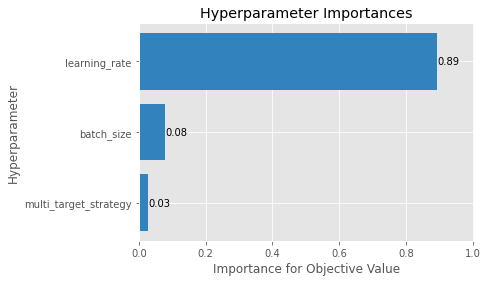

In [7]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(best.backend);

The final step is to train using the optimal parameters and check the model's performance again using the `evaluate()` method:

In [8]:
trainer.apply_hyperparameters(best.hyperparameters, final_model=True) # replaces model_init with a fixed model
trainer.train()

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 970
  Num epochs = 1
  Total optimization steps = 61
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/61 [00:00<?, ?it/s]

In [9]:
metrics = trainer.evaluate()
best.objective, metrics

Applying column mapping to evaluation dataset
***** Running evaluation *****


(0.3973333333333333, {'accuracy': 0.408})